# mnist project

## 1.import

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import TensorBoard, History
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## 2.load data 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [3]:
print(type(x_test))

selected_samples = np.zeros(10)
l = []
i = 0
while len(l)<10:
    if y_test[i] not in l:
        l.append(y_test[i])
        selected_samples[y_test[i]] = int(i)
        i = i + 1
    else:
        i = i + 1
selected_samples = list(selected_samples)
selected_samples = [int(s) for s in selected_samples]

<class 'numpy.ndarray'>


In [4]:
def display_images(x_test, decoded_imgs, selected_samples, image_type=[], name='reconstruction'):    
    n = len(selected_samples)  # how many digits we will display
    plt.figure(figsize=(14, 8))
    plt.title('Comparison of original and reconstructed image using different initialization methods')
    image_type = ['Original Image']+image_type
    for j in range(len(image_type)):
        ax = plt.subplot(len(image_type), n+2, (j*(n+2)+1))
        ax.text(0, 0.5, image_type[j], fontsize=16)
        ax.axis("off")
        
    for i in range(n):

        # display original
        ax = plt.subplot(len(image_type), n+2, i + 3)
        plt.imshow(x_test[selected_samples[i]].reshape(28, 28))
        plt.gray()
        ax.axis("off")

        for j in range(1,len(image_type)):
            # display reconstruction with different initialization
            ax = plt.subplot(len(image_type), n+2, i + 3 + (j)*(n+2))
            plt.imshow(decoded_imgs[image_type[j]][selected_samples[i]].reshape(28, 28))
            plt.gray()
            ax.axis("off")
    plt.tight_layout()        
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.savefig(name+'.png', dpi=200)
    plt.show()

In [5]:
def build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)):
    
    if initializer!='nmf':
        input_img = Input(shape=(784,))
        encoded = Dense(128, activation='relu', kernel_initializer=initializer)(input_img)
        encoded = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
        encoded = Dense(32, activation='relu', kernel_initializer=initializer)(encoded)

        decoded = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
        decoded = Dense(128, activation='relu', kernel_initializer=initializer)(decoded)
        decoded = Dense(784, activation='sigmoid', kernel_initializer=initializer)(decoded)
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
        
    else:
        input_img = Input(shape=(784,))
        encoded = Dense(128, activation='relu')(input_img)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dense(32, activation='relu')(encoded)
        
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dense(784, activation='sigmoid')(decoded)
        
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
    
        init_weights = get_nmf_init_weights([784, 128, 64, 32])
        autoencoder.set_weights(init_weights)
    
    autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.summary()
    
    return autoencoder

In [6]:
methods = ['RandomNormal', 'GlorotNormal']
small_sample_size = 3000

Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...


FileNotFoundError: [Errno 2] No such file or directory: 'images/mnist_digit_reconstruction_all_50.png'

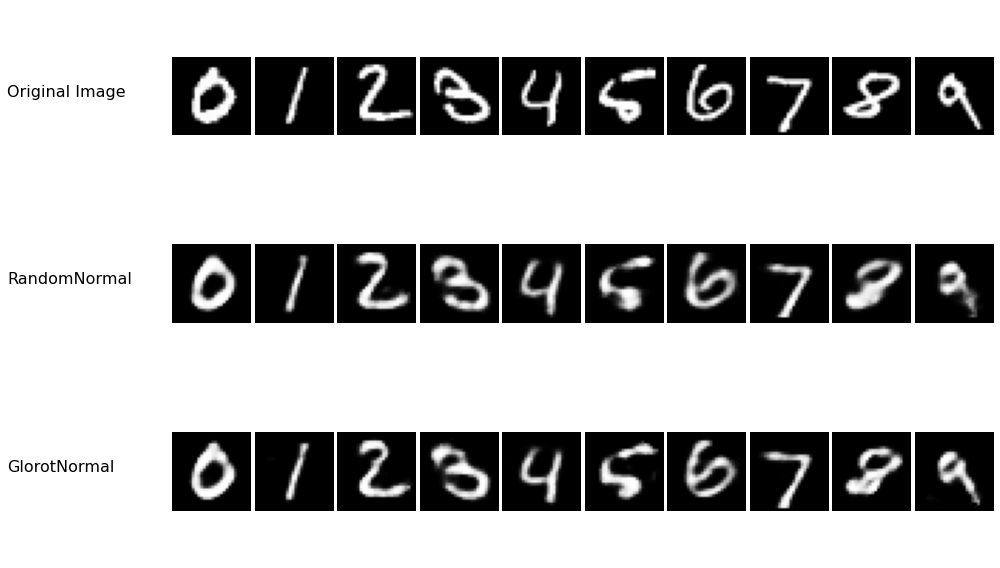

In [7]:
sample_size='all'
epochs = 50
autoencoders = {}
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train, x_train,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test)
    
display_images(x_test, decoded_imgs, selected_samples, image_type=methods, name='images/mnist_digit_reconstruction_'+str(sample_size)+'_'+str(epochs))